# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.

The dataset is montly_champagne_sales

## 02 - Load Data
Let's start by loading the time series of the challenge

In [1]:
import pandas as pd
import numpy as np
import statsmodels

In [21]:
mydateparser = lambda x: pd.datetime.strptime(x, '%m-%y')

In [23]:
df = pd.read_csv("data\monthly_champagne_sales.csv", header=0, index_col=0, parse_dates=['Month'])

In [24]:
df

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


👉 Convert dataframe with datetime objects as index to make it look like this
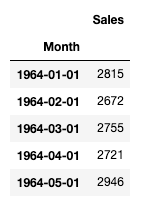

In [ ]:
df.set_index('Month',inplace=True)

In [7]:
df

,Sales
Month,
1964-01,2815
1964-02,2672
1964-03,2755
1964-04,2721
1964-05,2946
...,...
1972-05,4618
1972-06,5312
1972-07,4298


## 04 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

<AxesSubplot:xlabel='Month'>

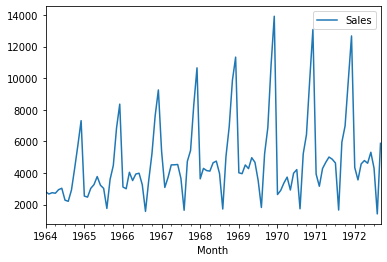

In [25]:
from matplotlib import pyplot
df.plot()

If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

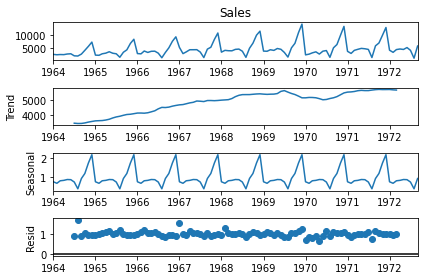

In [27]:
components = seasonal_decompose(df['Sales'], model='multiplicative')
 
components.plot();

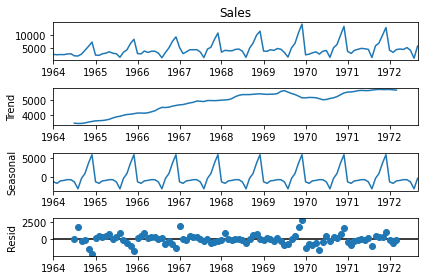

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(df['Sales'], model='additive')
result.plot()
pyplot.show()

Text(0.5, 1.0, 'Time series without seasonality')

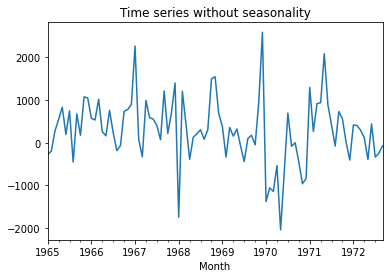

In [31]:
seasonal = components.seasonal
seasonal.head(4)
df["seasonal"] = seasonal
seasonal_diff_ts = df['Sales'] - df['Sales'].shift(12)
seasonal_diff_ts.dropna(inplace  =True)
seasonal_diff_ts.plot()
pyplot.title('Time series without seasonality')
👉 De-seasonalize this time serie using the decomposition of your choice

☝️ We could fit an ARIMA model on a "de-seasonalized" version of this time serie, and then re-compose it back after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time serie!

## 05 - Split the data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1970 for training and after for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [34]:
df_train = df[df.index.year != 1972]['Sales']
df_test = df[df.index.year == 1972]['Sales']

print('train examples: ', df_train.shape[0])
print('test examples: ', df_test.shape[0])

train examples:  96
test examples:  9


In [35]:
df_test

Month
1972-01-01    4348
1972-02-01    3564
1972-03-01    4577
1972-04-01    4788
1972-05-01    4618
1972-06-01    5312
1972-07-01    4298
1972-08-01    1413
1972-09-01    5877
Name: Sales, dtype: int64

## 06 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [36]:
from statsmodels.tsa.stattools import adfuller
def dfuller(series):
    dftest = adfuller(series, autolag='AIC')
    values_names = ['Test Statistic','p-value','no. of lags Used','Number of Observations Used']
    for value_name,value in list(zip(values_names,dftest)):
        print(value_name,': ', value)
    print('critical values: ',dftest[4])

In [37]:
dfuller(df_train)

Test Statistic :  -1.6205567758335102
p-value :  0.47243741362400016
no. of lags Used :  11
Number of Observations Used :  84
critical values:  {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}


The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

In [38]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

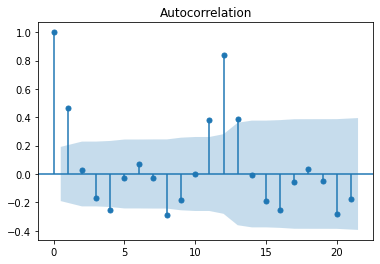

In [41]:
plot_acf(df['Sales']);

### Step 2 - Seasonal differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, and plot the differenced data and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

In [43]:
def make_plot(series,window, title = ''):
    rollmean = series.rolling(window=12).mean()
    rollstd = series.rolling(window =12).std()
    pyplot.figure(figsize = (8,5))
    series.plot()
    rollmean.plot(label = 'rolling mean')
    rollstd.plot(label = 'rolling std')
    pyplot.ylabel('Sales in millions')
    pyplot.title(title)
    pyplot.legend()
    pyplot.show()

In [51]:
df['seasional_first_difference'] = df['Sales'] - df['Sales'].shift(12)

In [52]:
seasonal_diff_df=df['seasional_first_difference'] 

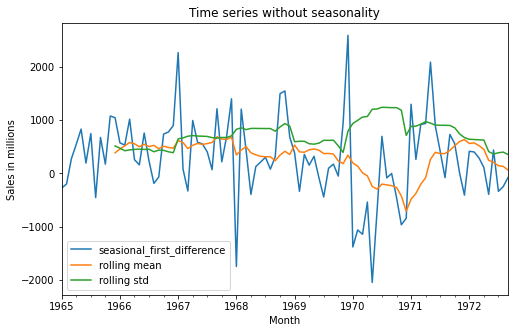

In [53]:
seasonal_diff_df.dropna(inplace  =True)
make_plot(seasonal_diff_df,12, 'Time series without seasonality')

In [55]:
dfuller(seasonal_diff_df)

Test Statistic :  -7.626619157213164
p-value :  2.060579696813685e-11
no. of lags Used :  0
Number of Observations Used :  92
critical values:  {'1%': -3.503514579651927, '5%': -2.893507960466837, '10%': -2.583823615311909}


In [56]:
df_acf = acf(seasonal_diff_df,nlags=40)
df_pacf = pacf(seasonal_diff_df,nlags =40)

C:\Users\Joe\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


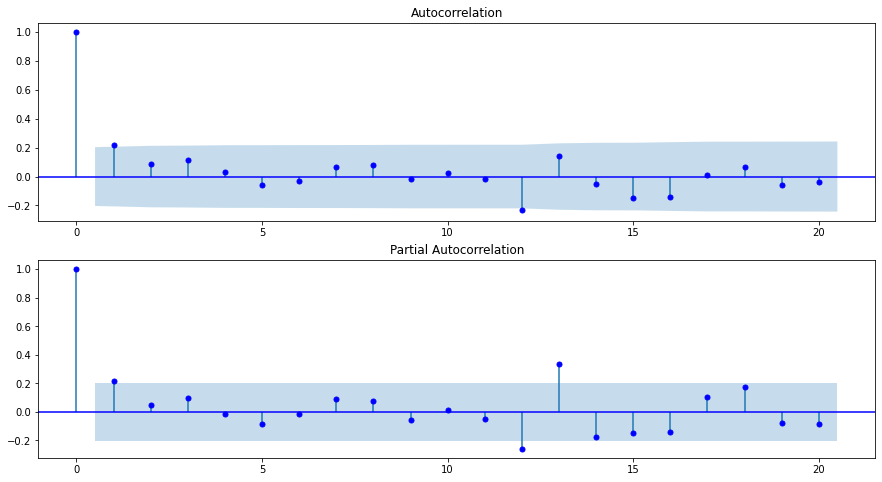

In [57]:
pyplot.figure(figsize = (15,8))
pyplot.subplot(211)
plot_acf(seasonal_diff_df, ax=pyplot.gca(), color ='blue')
pyplot.subplot(212)
plot_pacf(seasonal_diff_df, ax=pyplot.gca(),  color ='blue')
pyplot.show()

In [54]:
df

,Sales,seasonal,seasional_first_difference
Month,,,
1964-01-01,2815,0.754627,NaN
1964-02-01,2672,0.674224,NaN
1964-03-01,2755,0.807685,NaN
1964-04-01,2721,0.829951,NaN
1964-05-01,2946,0.874299,NaN
...,...,...,...
1972-05-01,4618,0.874299,-392.0
1972-06-01,5312,0.866200,438.0
1972-07-01,4298,0.740520,-335.0


☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order diff(1) on your diff(12) series.

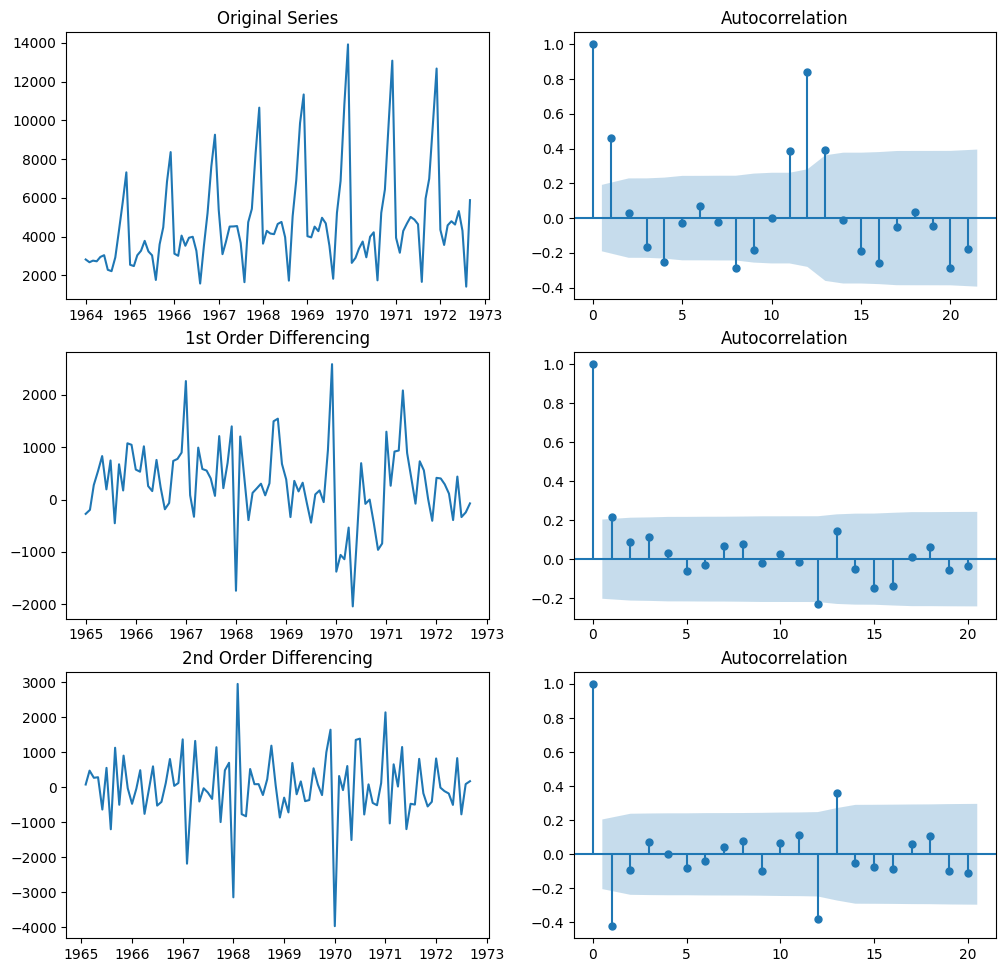

In [66]:

# Original Series
fig, axes = pyplot.subplots(3, 2, sharex=False,figsize=(12,12), dpi=100)
axes[0, 0].plot(df.Sales); axes[0, 0].set_title('Original Series')
plot_acf(df.Sales, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.Sales.diff(12)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Sales.diff(12).dropna(), ax=axes[1, 1]); 


# 2nd Differencing
axes[2, 0].plot(df.Sales.diff(12).diff(1)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.Sales.diff(12).diff(1).dropna(), ax=axes[2, 1])

pyplot.show()

👉 Additional differencing actually made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

### Step 4 - Select AR(p,P) and MA(q,Q) terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select MA number (`q`)
- MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

C:\Users\Joe\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


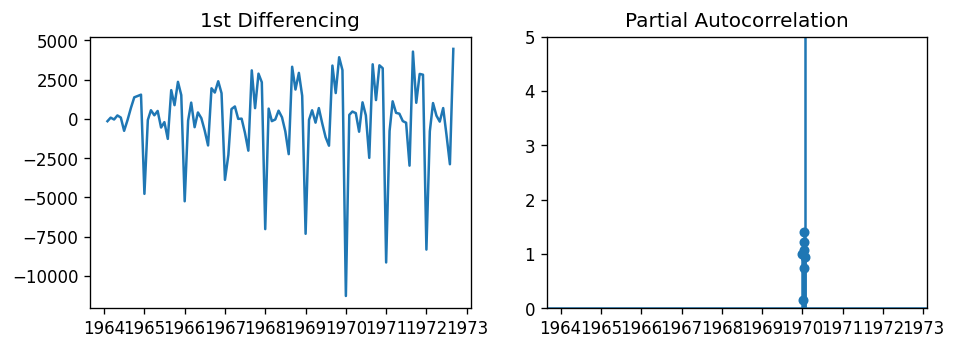

In [67]:
pyplot.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = pyplot.subplots(1, 2, sharex=True)
axes[0].plot(df.Sales.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.Sales.diff().dropna(), ax=axes[1])

pyplot.show()

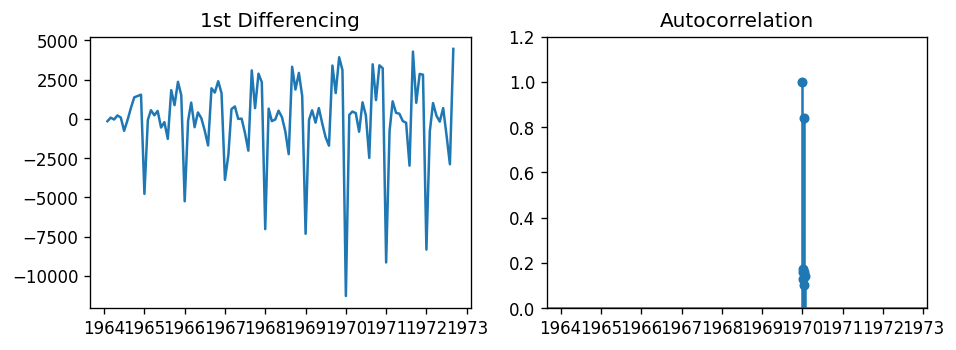

In [68]:
pyplot.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = pyplot.subplots(1, 2, sharex=True)
axes[0].plot(df.Sales.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.Sales.diff().dropna(), ax=axes[1])

pyplot.show()


☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let pdarima try values 1 and 0 for P and Q with a grid_search for us.
If you really want to find these coefficient by yourself, [Read here 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [89]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model = pm.auto_arima(df_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,
                      start_Q=0,  
                      max_Q=2,              # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      max_P=2,
                      D=1, 
                      n_jobs=-1,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

C:\Users\Joe\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1362.359, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1361.110, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1361.793, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1372.435, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1361.903, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1361.866, Time=0.57 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1362.425, Time=0.74 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1361.430, Time=0.16 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1363.845, Time=1.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1363.126, Time=0.18 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1362.764, Time=0.95 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1362.846, Time=1.37 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1360.664, Time=1.36 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1361.931, Time=0.08 sec
 ARIMA(0,0,1)(2,1,0

The best model found is `ARIMA(0,0,0)(0,1,0)[12]` ! 
This means that the Time Serie condidered does not justify adding any "autoregressive" nor "moving average" modelling beyond simple "seasonal differencing".

Such "poor" model is only likely to predict a repetition of the last seasonal pattern detected, alongwith the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set, in order to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as Pandas Series, and index them by the same index than your `y_test`

In [94]:
pred, conf = model.predict(n_periods=len(df_test), return_conf_int=True, index= df_test.index)

In [97]:
lower = pd.Series(conf[:,0], index=df_test.index)
central = pd.Series(pred, index=df_test.index)
upper = pd.Series(conf[:,1], index=df_test.index)


👇 Run the cell below to plot your predictions against reality

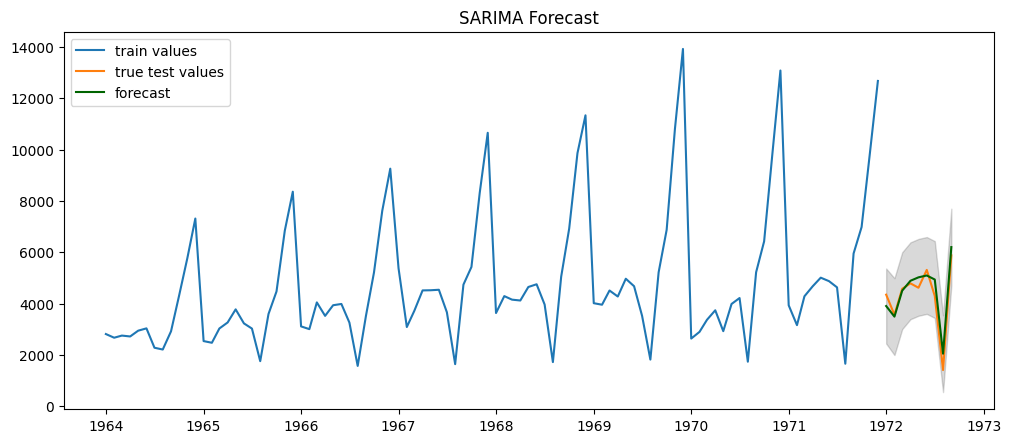

In [99]:
# Plot
pyplot.figure(figsize=(12,5), dpi=100)
pyplot.plot(df_train, label = "train values")
pyplot.plot(df_test, label = "true test values")
pyplot.plot(central, color='darkgreen',label = "forecast")
pyplot.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

pyplot.title("SARIMA Forecast")
pyplot.legend()
pyplot.show()

👉 Try to assign non-null values to  `p`,`d`,`P`,`D` on your SARIMA and re-plot this chart to compare effects!

# OPTIONAL - Machine Learning Approach

### Model with forecast horizon = 1 month only

We will now fit a non linear model such as a random forest. The idea is to predict a value from the last ones. 

👉 Create new columns in `df` that are shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [ ]:
# Add lagged values

# Drop nan


# create df_train and df_test 


In [ ]:
# Keep track of test_indexes

In [ ]:
# Create X, y

👉 Instanciate (don't train) a `random forest` algorithm to predict Sales based in your shifted features

👉 You can use the following function to test it. It takes the true y values (`data` which should be a Numpy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm) and the shifted columns (`full_X` which should be a Numpy array).

In [ ]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [ ]:
results = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X.values)

In [ ]:
print('Mean Absolute Prediction Error MAPE')
results[2]

In [ ]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columnns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect to isolate the trend and allow the algorithm to learn it. Also, plot these data.


In [ ]:
# Extract the trend using a well chosen moving average

You can also add a more smoothing predictor using the exponential moving average (hint: method `.ewm` with `halflife` of 2, 3 and 12), that statistically optimizes an AR process. Plot also the data.

You should see a better MAPE!

Try to look at the importance of each feature. What do you find?


### Out-of-sample forecast models

Let's now try to beat SARIMA in the "out-of-sample" prediction. 

👉 Train _one model per horizon of forecast_ (from `1` month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA